# Temperature Prediction Demo

This notebook demonstrates how to load the trained CNN-LSTM model and make temperature field predictions.

## 1. Setup and Imports

In [1]:
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from lasernet.temperature.model import CNN_LSTM
from lasernet.temperature.data import TemperatureDataset

sys.path.insert(0, "../src")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Load the Trained Model

In [2]:
# Load the trained model from checkpoint
checkpoint_path = Path("../models/best_temperature_model-v1.ckpt")

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Model checkpoint not found at {checkpoint_path}")

# Load model from checkpoint
model = CNN_LSTM.load_from_checkpoint(checkpoint_path)
model = model.to(device)

# Convert model to float16 to save memory
# Use .type() instead of .half() to convert all parameters and buffers
model = model.type(torch.float16)

model.eval()  # Set to evaluation mode

print(f"Model loaded successfully from {checkpoint_path}")
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Model has {model.count_parameters():,} trainable parameters")

Model loaded successfully from ../models/best_temperature_model-v1.ckpt
Model dtype: torch.float16
Model has 480,257 trainable parameters


## 3. Load Test Dataset

In [3]:
# Load training dataset to get normalization stats
train_dataset = TemperatureDataset(
    data_path=Path("../data/processed/"),
    split="train",
    normalize=True,
    plane="xz",
    sequence_length=3,
    target_offset=1
)

train_stats = (train_dataset.temp_min, train_dataset.temp_max)
print(f"Training normalization stats: min={train_stats[0]:.2f}, max={train_stats[1]:.2f}")

# Load test dataset with same normalization
test_dataset = TemperatureDataset(
    data_path=Path("../data/processed/"),
    split="test",
    normalize=True,
    norm_stats=train_stats, # type: ignore
    plane="xz",
    sequence_length=3,
    target_offset=1
)

print(f"Test dataset loaded: {len(test_dataset)} samples")
print(f"Data shape: {test_dataset.shape}")

2026-01-17 15:29:22 [INFO] train split computed normalization stats: min=300.00, max=4648.00
2026-01-17 15:29:23 [INFO] test split using provided normalization stats: min=300.00, max=4648.00


Training normalization stats: min=300.00, max=4648.00
Test dataset loaded: 561 samples
Data shape: torch.Size([564, 465, 47])


## 4. Make a Prediction

In [4]:
# Select a random sample from the test set
sample_idx = np.random.randint(0, len(test_dataset))
print(f"Using test sample index: {sample_idx}")

# Get input sequence and target
input_seq, target = test_dataset[sample_idx]

# Add batch dimension and convert to float16 to match model dtype
input_batch = input_seq.unsqueeze(0).half().to(device)  # [1, seq_len, 1, H, W]
target_batch = target.unsqueeze(0).half().to(device)    # [1, 1, H, W]

# Debug: Print dtypes
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Input batch dtype: {input_batch.dtype}")
print(f"Target batch dtype: {target_batch.dtype}")

# Make prediction
with torch.no_grad():
    prediction = model(input_batch)  # [1, 1, H, W]

# Move back to CPU for visualization
input_seq_cpu = input_seq.cpu()
target_cpu = target.cpu()
prediction_cpu = prediction.cpu()

print(f"Input sequence shape: {input_seq_cpu.shape}")
print(f"Target shape: {target_cpu.shape}")
print(f"Prediction shape: {prediction_cpu.shape}")

Using test sample index: 98
Model dtype: torch.float16
Input batch dtype: torch.float16
Target batch dtype: torch.float16
Input sequence shape: torch.Size([3, 1, 465, 47])
Target shape: torch.Size([1, 465, 47])
Prediction shape: torch.Size([1, 1, 465, 47])


## 5. Visualize Results

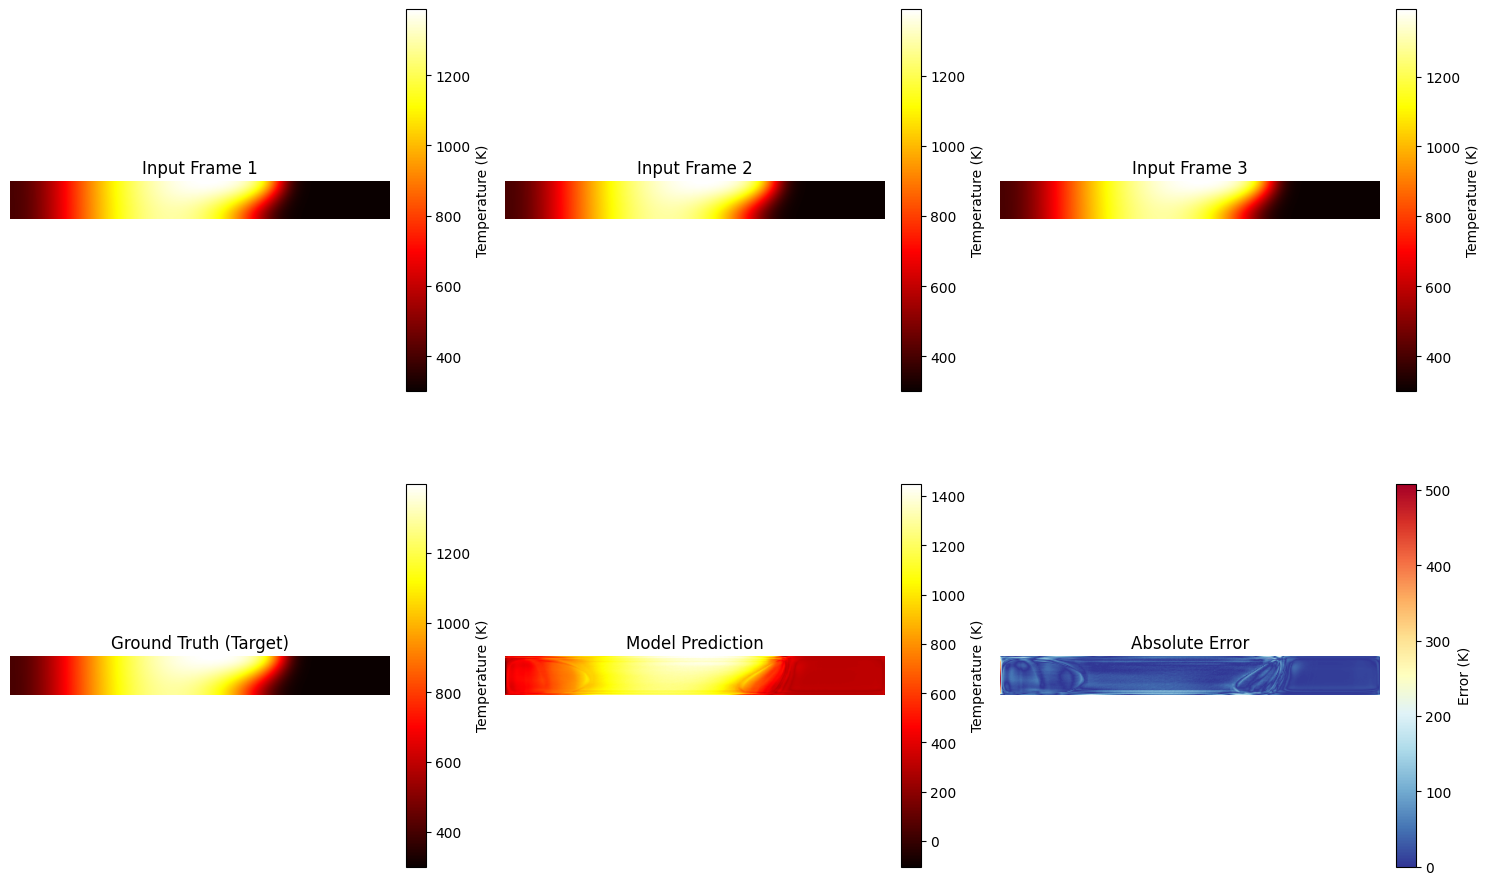


Prediction Statistics:
  MSE (normalized): 0.000077
  MAE (actual temp): 24.34 K
  Max Error: 507.75 K
  Target temp range: [300.00, 1397.00] K
  Prediction temp range: [-104.00, 1448.00] K


In [16]:
# Denormalize for better visualization
input_seq_denorm = test_dataset.denormalize(input_seq_cpu)
target_denorm = test_dataset.denormalize(target_cpu)
prediction_denorm = test_dataset.denormalize(prediction_cpu)

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot input sequence (top row)
for i in range(3):
    ax = axes[0, i]
    im = ax.imshow(input_seq_denorm[i, 0].T, cmap='hot', aspect='equal', origin="lower")
    ax.set_title(f'Input Frame {i+1}')
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Temperature (K)')

# Plot ground truth (bottom left)
ax = axes[1, 0]
im = ax.imshow(target_denorm[0].T, cmap='hot', aspect='equal', origin="lower")
ax.set_title('Ground Truth (Target)')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Temperature (K)')

# Plot prediction (bottom middle)
ax = axes[1, 1]
im = ax.imshow(prediction_denorm[0, 0].T, cmap='hot', aspect='equal', origin="lower")
ax.set_title('Model Prediction')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Temperature (K)')

# Plot error map (bottom right)
ax = axes[1, 2]
error = np.abs(target_denorm[0].T.numpy() - prediction_denorm[0, 0].T.numpy())
im = ax.imshow(error, cmap='RdYlBu_r', aspect='equal', origin="lower"  )
ax.set_title('Absolute Error')
ax.axis('off')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Error (K)')

plt.tight_layout()
plt.savefig('prediction_demo.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
mse = torch.nn.functional.mse_loss(prediction[0], target_batch[0]).item()
mae = torch.abs(prediction_denorm[0, 0] - target_denorm[0]).mean().item()
max_error = error.max()

print(f"\nPrediction Statistics:")
print(f"  MSE (normalized): {mse:.6f}")
print(f"  MAE (actual temp): {mae:.2f} K")
print(f"  Max Error: {max_error:.2f} K")
print(f"  Target temp range: [{target_denorm.min():.2f}, {target_denorm.max():.2f}] K")
print(f"  Prediction temp range: [{prediction_denorm.min():.2f}, {prediction_denorm.max():.2f}] K")

## 6. Evaluate Multiple Samples

In [ ]:
# Evaluate on multiple test samples
num_samples = 100
mse_losses = []
mae_losses = []

print(f"Evaluating on {num_samples} random test samples...")

for _ in range(num_samples):
    idx = np.random.randint(0, len(test_dataset))
    input_seq, target = test_dataset[idx]
    
    # Convert to float16 to match model dtype
    input_batch = input_seq.unsqueeze(0).half().to(device)
    target_batch = target.unsqueeze(0).half().to(device)
    
    with torch.no_grad():
        prediction = model(input_batch)
    
    # Calculate losses
    mse = torch.nn.functional.mse_loss(prediction, target_batch).item()
    
    # Denormalize for MAE calculation
    pred_denorm = test_dataset.denormalize(prediction.cpu().float())
    target_denorm = test_dataset.denormalize(target.cpu().unsqueeze(0))
    mae = torch.abs(pred_denorm - target_denorm).mean().item()
    
    mse_losses.append(mse)
    mae_losses.append(mae)

# Print summary statistics
print(f"\nEvaluation Results ({num_samples} samples):")
print(f"  Average MSE (normalized): {np.mean(mse_losses):.6f} ± {np.std(mse_losses):.6f}")
print(f"  Average MAE (actual temp): {np.mean(mae_losses):.2f} ± {np.std(mae_losses):.2f} K")
print(f"  Median MAE: {np.median(mae_losses):.2f} K")
print(f"  Min MAE: {np.min(mae_losses):.2f} K")
print(f"  Max MAE: {np.max(mae_losses):.2f} K")

## 7. Visualize Loss Distribution

In [ ]:
# Plot loss distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# MSE distribution
ax1.hist(mse_losses, bins=30, edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(mse_losses), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mse_losses):.6f}')
ax1.set_xlabel('MSE (normalized)')
ax1.set_ylabel('Frequency')
ax1.set_title('MSE Distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MAE distribution
ax2.hist(mae_losses, bins=30, edgecolor='black', alpha=0.7, color='orange')
ax2.axvline(np.mean(mae_losses), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mae_losses):.2f} K')
ax2.set_xlabel('MAE (K)')
ax2.set_ylabel('Frequency')
ax2.set_title('MAE Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('loss_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Custom Prediction Function

In [ ]:
def predict_temperature(model, input_sequence, dataset, device='cpu'):
    """
    Make a temperature prediction from an input sequence.
    
    Args:
        model: Trained CNN_LSTM model
        input_sequence: torch.Tensor of shape [seq_len, 1, H, W] (normalized)
        dataset: TemperatureDataset instance for denormalization
        device: Device to run inference on
        
    Returns:
        prediction: torch.Tensor of shape [H, W] (denormalized)
    """
    model.eval()
    
    # Add batch dimension and convert to float16
    input_batch = input_sequence.unsqueeze(0).half().to(device)
    
    # Make prediction
    with torch.no_grad():
        pred_normalized = model(input_batch)  # [1, 1, H, W]
    
    # Remove batch dimension, convert to float32, and denormalize
    pred_denormalized = dataset.denormalize(pred_normalized.cpu().float()[0])  # [1, H, W]
    
    return pred_denormalized[0]  # [H, W]

# Test the function
print("Testing custom prediction function...")
test_idx = 42
test_input, test_target = test_dataset[test_idx]

prediction = predict_temperature(model, test_input, test_dataset, device=device)
target_denorm = test_dataset.denormalize(test_target.unsqueeze(0))[0]

mae = torch.abs(prediction - target_denorm).mean().item()
print(f"Prediction MAE: {mae:.2f} K")
print(f"Prediction shape: {prediction.shape}")